# Fantasy Football Train an Agent 

Below an RL agent will be trained to decide which player should be removed each week or whether thme current team should be kept.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import json
import csv
from IPython import display
%matplotlib inline
import seaborn as sns
import sys
sys.path.append('../')
from FPL.fpl import *
from itertools import count
import pickle


In [2]:
from FPL.next_actions.agent import *
from FPL.next_actions.dqn import *

/Users/diane.odonoghue/Library/CloudStorage/OneDrive-Accenture/Documents/RL/FPL/RLFantasyPremierLeague/.fpl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data into the environment

All the below info is from 2021

In [3]:
from FPL.load_data import *

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Train the model

The model below will be trainined using a DQN model. 

The model will decide what player should be removed from the team, while we will swap in the next "best" player to replace them. Here the "best" player is defined as the player that has accumulated the most points over the season so far that is available.


The agent that is used in this example, can be explained in detail [here](https://innersource.accenture.com/projects/DSMLE/repos/expertgrp_reinforcementlearning/browse/connect4/connect_X.ipynb)

In [5]:
## Set up the environment
env = FPL(player_info_refined_all, fixture_data_finished, teams)
agent = trainAgent(env.current_player_state)

## Increase the number of episodes to train
num_episodes = 10
# control how lagged is target network by updating every n episodes
TARGET_UPDATE = 5

steps_done = 0
reward_list = []
## Current players is the number of players in player pool
current_players_ids = np.arange(15)
## Choose to skip, if greater index than all available player ids
skip_idx = 15
current_player_ids = np.append(current_players_ids, skip_idx)

iteration: 0


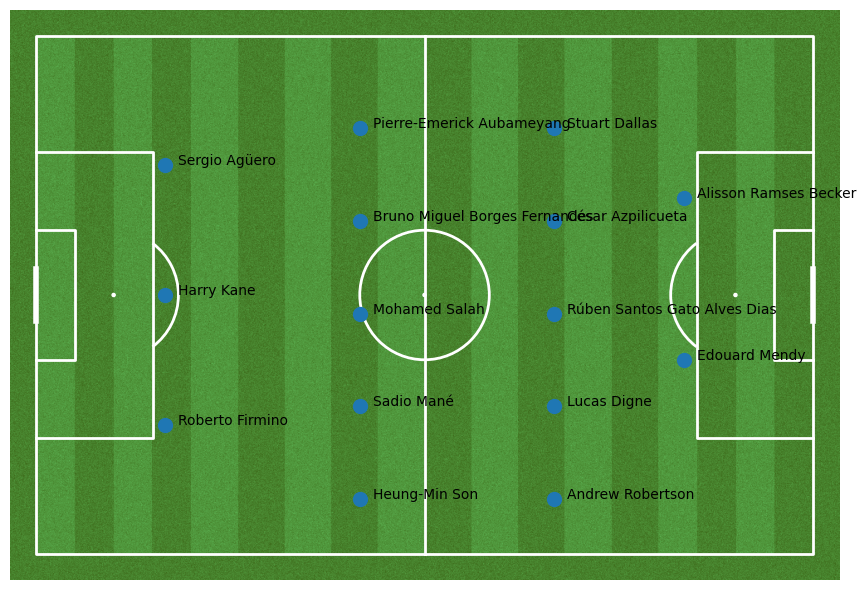

Running iteration 0, reward 2130.0, transfers made 35
iteration: 1


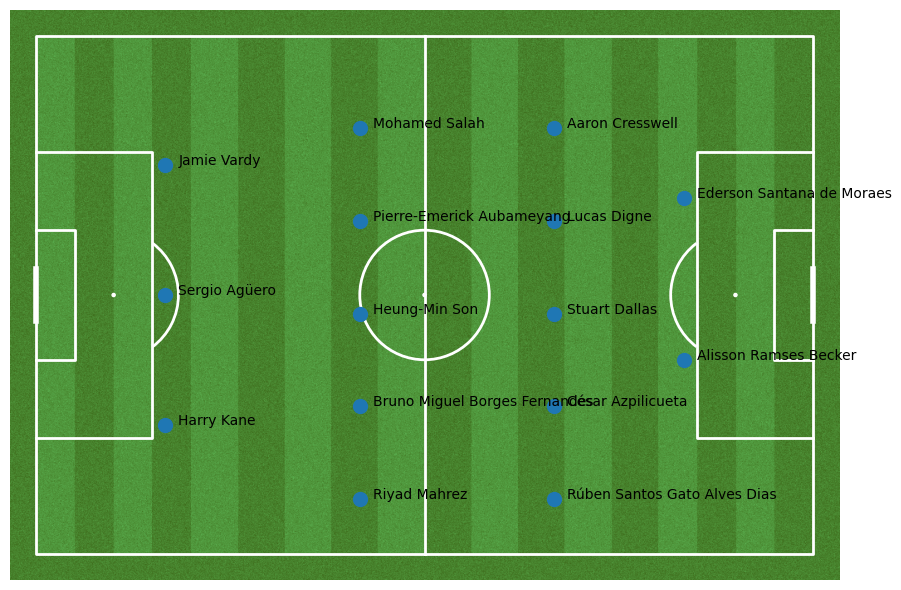

Running iteration 1, reward 2244.0, transfers made 35
iteration: 2


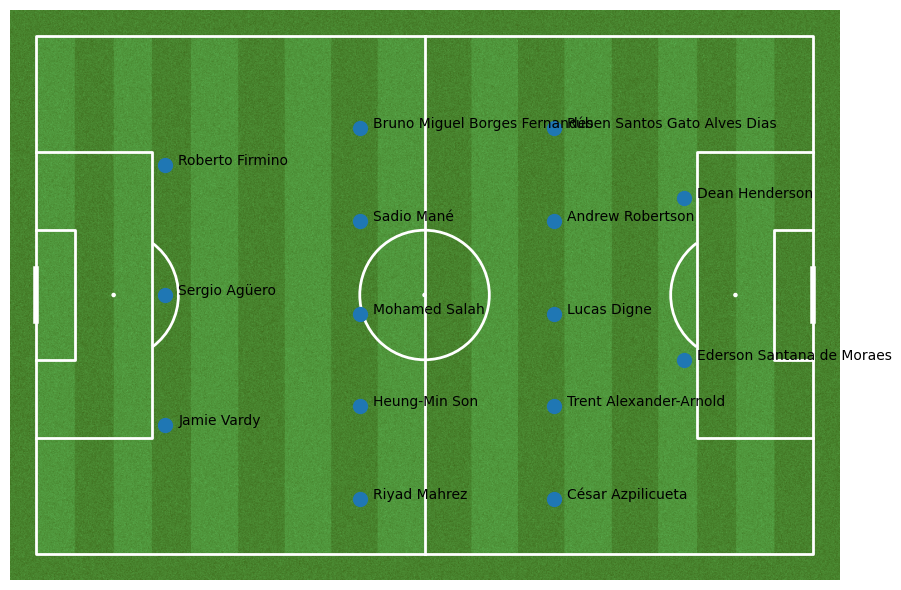

Running iteration 2, reward 2153.0, transfers made 33
iteration: 3


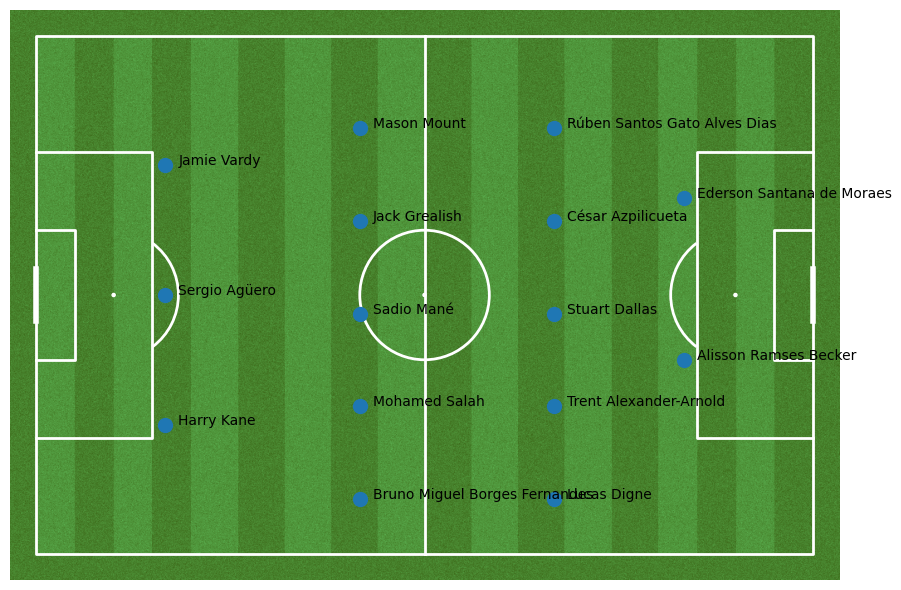

Running iteration 3, reward 2085.0, transfers made 32
iteration: 4


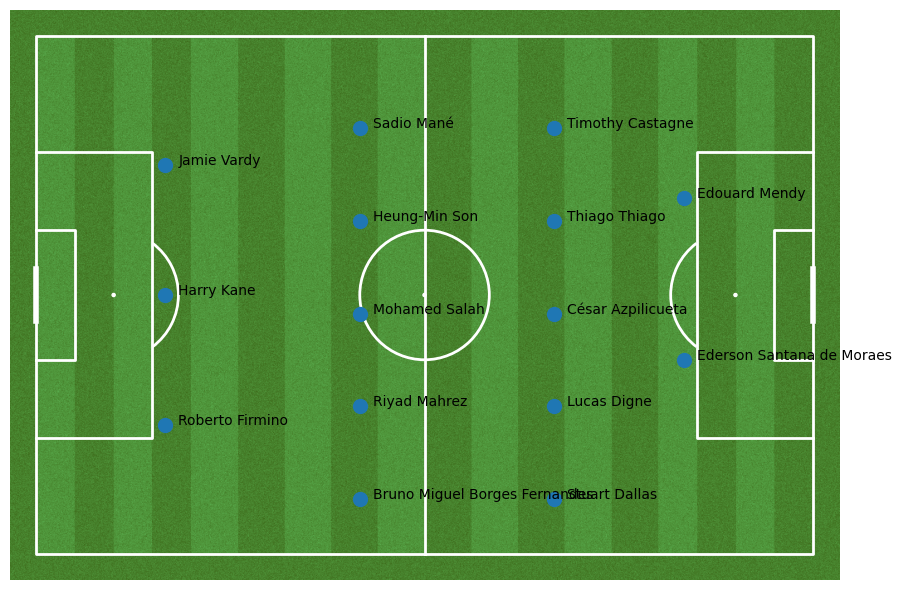

Running iteration 4, reward 2017.0, transfers made 36
iteration: 5


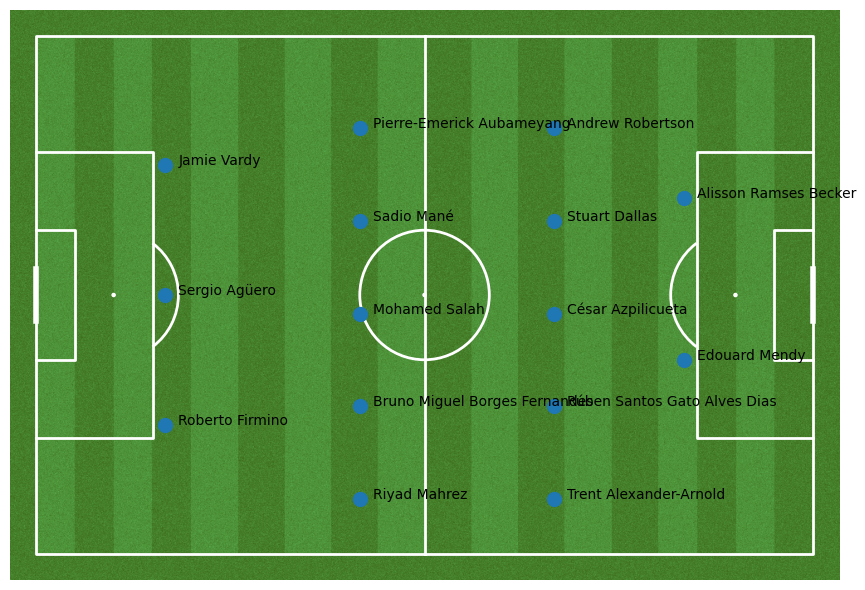

Running iteration 5, reward 2211.0, transfers made 35
iteration: 6


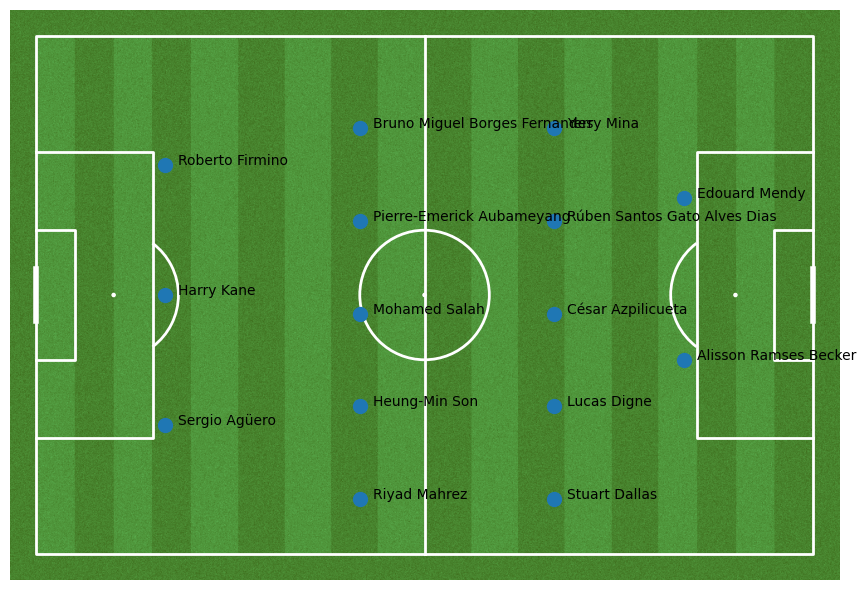

Running iteration 6, reward 2147.0, transfers made 36
iteration: 7


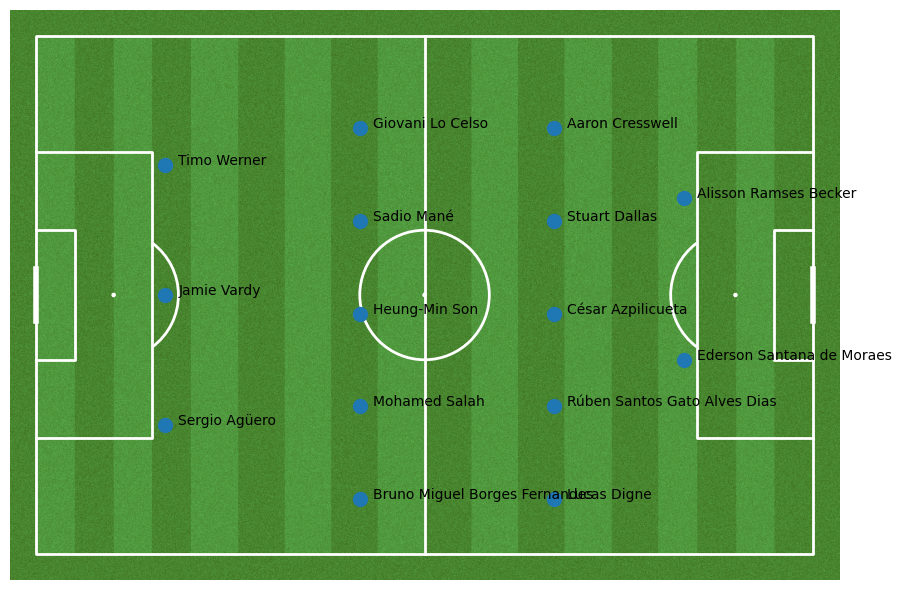

Running iteration 7, reward 2035.0, transfers made 33
iteration: 8


In [6]:
for i in range(num_episodes):
    print("iteration: "+str(i))
    steps_done = 0
    # Reset board for each episode
    env = FPL(player_info_refined_all, fixture_data_finished, teams)
    ## Play the first match
    ## No swaps are needed at this point
    reward_p1 = env._step(player_match_info_refined, 0, [], [])
        
    # Keep going until someone wins or loses
    for t in count():
        # Get the current state of how every player is performing
        player_state = env.current_player_state.copy()
        current_player_names = env.current_player_names.copy()
        
        if t > 0:
            # Dump any reward player actions
            agent.memory.dump([old_state, action_player_id, reward_p1, player_state])
        
        ## Choose what action to take
        action_player_name, action_player_id = agent.select_action(player_state, current_player_ids, current_player_names, steps_done)
        ## Check if a transfer is to be made
        if action_player_name:
            ## Allow only for one transfer at the moment
            transfers = 1
            ## Build function to update list week to week
            available_players = env._get_available_players()
            ## get the best player to replace them
            new_player_name = env._get_best_available_performing_player(action_player_name, available_players)
            
            ## Hard code only 1 valid transfer for now
            ## TODO - allow for more
            old_players = [action_player_name]
            new_players = [new_player_name]  

        else:
            transfers = 0 
            old_players = []
            new_players = []

        ## increment the steps
        steps_done += 1
        ## Update the reward

        reward_p1 = env._step(player_match_info_refined, transfers, old_players, new_players)
        
        ## Check if the league is over
        if env.episode_over:
            ## Dump the state - action - reward in memory
            agent.memory.dump([player_state, action_player_id, reward_p1, None])
            ## Add finishing reward to list
            reward_list.append(reward_p1)
            env.display_current_team()
            plt.show()
            print('Running iteration {}, reward {}, transfers made {}'.format(i, reward_p1, env.transfers_made))
            break

        ## If environment is not over, the current state becomes the old state
        old_state = player_state
        
    # Perform one step of the optimization (on the policy network)
    agent.optimize_model()
        
    # update the target network, copying all weights and biases in DQN
    if i % TARGET_UPDATE == TARGET_UPDATE - 1:
        agent.update_target()
        path = 'swap_option_model.pth'
        torch.save(agent.policy_net.state_dict(), path)
        
        with open("swap_option_model_list", "wb") as fp:   #Pickling
            pickle.dump(reward_list, fp)
        
        
print('Complete')